In [3]:
%run training_functions.ipynb

In,  Out,  get_ipython,  exit,  quit,  open,  accelerate,  datasets,  evaluate,  math,  np,  peft,  pickle,  pytest,  ipytest,  pd,  transformers,  load_dataset,  load_dataset_builder,  get_dataset_split_names,  get_dataset_config_names,  LoftQConfig,  LoraConfig,  get_peft_model,  AutoModelForCausalLM,  AutoTokenizer,  TrainingArguments,  Trainer,  SFTTrainer,  SFTConfig,  @py_builtins,  @pytest_ar,  model_from_pkl,  map_data,  print_trainable_parameters,  metric,  comp_metrics_output,  compute_metrics,  make_trainer,  get_dataframe,  get_training_output,  i,  

In [1]:
# import datasets
# import peft
# import pickle
# import pytest, ipytest
# import transformers

# from datasets import(
#     load_dataset, 
#     load_dataset_builder,
#     get_dataset_split_names,
#     get_dataset_config_names,
# )

# from peft import(
#     LoftQConfig,
#     LoraConfig,
#     get_peft_model,
# )

# from transformers import(
#     AutoModelForCausalLM,
#     AutoTokenizer,
#     TrainingArguments,
#     Trainer
# )
# from trl import SFTTrainer, SFTConfig
# # allows fast processing of datasets

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-03 19:29:43.726099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743708583.743585 3448502 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743708583.748943 3448502 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743708583.764337 3448502 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 

## Imported Functions
1. model_from_pkl(model): extracts ML model from pkl file
2. map_data(data, model, tokenizer): performs preprocessing/tokenization on data
3. make_trainer(m_model, train_data, test_data, config, args): creates training object with model, training arguments, train/test data, a configuration, and evaluation function
4. compute_metrics(eval_pred): used in the trainer, calculates prediction accuracy/validation loss
5. get_training_output(trainer, keys: list): extracts data from training logs
6. get_dataframe(training_output: list, strategy): used in get_training_output, puts training data into dataframe/graph form

In [3]:
ds_builder1=load_dataset_builder("LongSafari/open-genome", "stage1")
print(ds_builder1.info.features)
ds_builder2=load_dataset_builder("LongSafari/open-genome", "stage2")
print(ds_builder2.info.features)
ds_builder3=load_dataset_builder("LongSafari/open-genome", "sample")
print(ds_builder3.info.features)

{'record': Value(dtype='string', id=None), 'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}
{'text': Value(dtype='string', id=None)}


In [4]:
ds_gs=load_dataset("LongSafari/open-genome", "sample")
get_dataset_split_names("LongSafari/open-genome", "sample")

['validation']

In [5]:
ds_gst1_train=load_dataset("LongSafari/open-genome", "stage1", split="train[:500]")
#print(ds_gst1[50])
ds_gst1_test=load_dataset("LongSafari/open-genome", "stage1", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage1"))
ds_gst2_train=load_dataset("LongSafari/open-genome", "stage2", split="train[:500]")
ds_gst2_test=load_dataset("LongSafari/open-genome", "stage2", split="test[:50]")
print(get_dataset_split_names("LongSafari/open-genome", "stage2"))

['train', 'validation', 'test']
['train', 'validation', 'test']


In [6]:
mistral, mistral_tokenizer=model_from_pkl("Mistral-7B-Instruct-v0.1")

In [7]:
m_tokenized_genome_samples=map_data(ds_gs, mistral, mistral_tokenizer)

In [8]:
m_tokenized_stage1_train=map_data(ds_gst1_train, mistral, mistral_tokenizer)
m_tokenized_stage1_test=map_data(ds_gst1_test, mistral, mistral_tokenizer)

Map: 100%|██████████████████| 50/50 [00:00<00:00, 443.78 examples/s]


In [9]:
m_tokenized_stage2_train=map_data(ds_gst2_train, mistral, mistral_tokenizer)
m_tokenized_stage2_test=map_data(ds_gst2_test, mistral, mistral_tokenizer)

In [10]:
# to fine-tune with LoRA, instantiate a base model (as above)
# create LoraConfig where LoRA-specific parameters are defined
config=LoraConfig(
    #inference_mode=False,
    r=8, #rank of update matrices, lower value results in smaller matrices with fewer parameters
    lora_alpha=16, #LoRA scaling factor
    task_type="CAUSAL_LM",
    lora_dropout=0.1, # dropout probability of LoRA layers
    bias="none", # specifies if bias parameters should be trained
    #modules_to_save=["decode_head"] #models apart from LoRA layers that are trainable
)

In [11]:
mis_lora_model=get_peft_model(mistral, config)
print_trainable_parameters(mis_lora_model)

trainable params: 3407872 || all params: 7245139968 || trainable%: 0.05


In [12]:
m_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="steps",
                                    logging_strategy="steps", 
                                    logging_steps=6, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

# Using the SFTConfig default values provides us with...
# num_train_epochs = 3.0
# eval_strategy: typing.Union[transformers.trainer_utils.IntervalStrategy, str] = 'no'
# per_device_train_batch_size = 8
# learning_rate = 2e-5
# gradient_checkpointing=False

Truncating eval dataset: 100%|█| 50/50 [00:00<00:00, 2178.43 example


In [13]:
m_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
6,0.652600,2.570826,0.026641
12,0.644100,2.527457,0.025937
18,0.631700,2.498986,0.027480
24,0.630300,2.483156,0.028301
30,0.626800,2.473331,0.028301
36,0.624100,2.467366,0.027891
42,0.620800,2.464118,0.028594
48,0.623100,2.462966,0.028555


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch

TrainOutput(global_step=48, training_loss=0.6316852221886317, metrics={'train_runtime': 817.7353, 'train_samples_per_second': 1.834, 'train_steps_per_second': 0.059, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.6316852221886317})

,loss,eval_loss,eval_accuracy
steps,,,
6,0.6526,2.570826,0.026641
12,0.6441,2.527457,0.025937
18,0.6317,2.498986,0.027480
24,0.6303,2.483156,0.028301
30,0.6268,2.473331,0.028301
36,0.6241,2.467366,0.027891
42,0.6208,2.464118,0.028594
48,0.6231,2.462966,0.028555


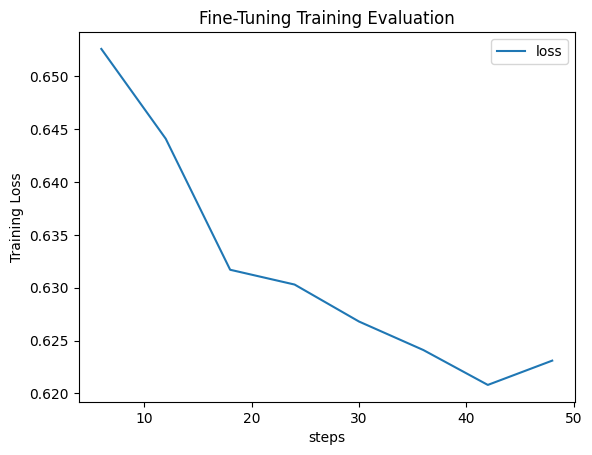

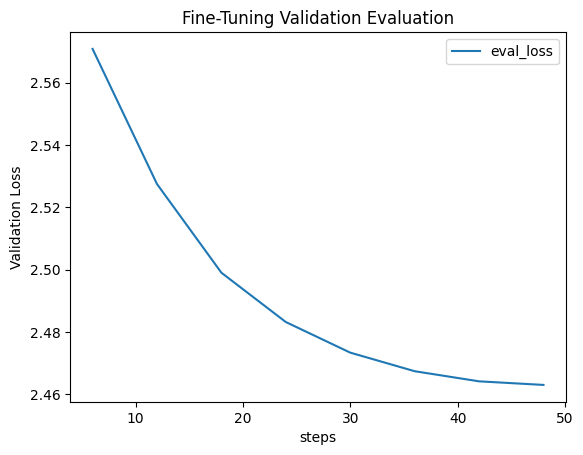

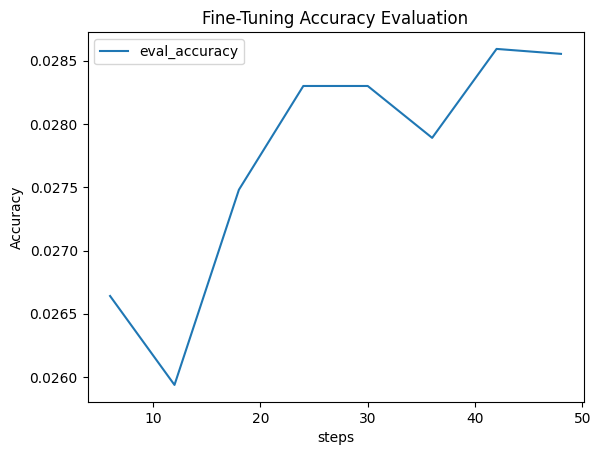

In [14]:
output=get_training_output(m_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [15]:
m2_trainer = make_trainer(mis_lora_model, m_tokenized_stage1_train, m_tokenized_stage1_test, config,
                          SFTConfig(output_dir="test_trainer", eval_strategy="epoch",
                                    logging_strategy="steps", 
                                    logging_steps=2, do_eval=True, 
                                    #max_length=1024,
                                    per_device_eval_batch_size=8,
                                   fp16=True))

In [16]:
m2_trainer.train()

/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.614500,2.441981,0.002363
2,0.612400,2.434001,0.006602
3,0.616900,2.431256,0.008516


/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/home/ac.cdavies/.vnv/lib/python3.12/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=48, training_loss=0.6159186561902364, metrics={'train_runtime': 361.097, 'train_samples_per_second': 4.154, 'train_steps_per_second': 0.133, 'total_flos': 6.5563250393088e+16, 'train_loss': 0.6159186561902364})

,loss,eval_loss,eval_accuracy
epoch,,,
1.0,0.6145,2.441981,0.002363
2.0,0.6124,2.434001,0.006602
3.0,0.6169,2.431256,0.008516


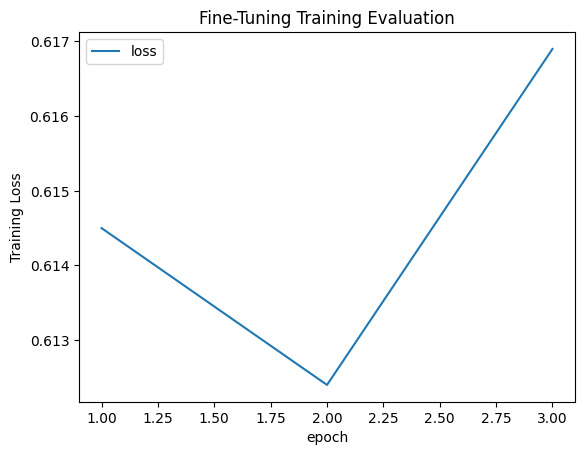

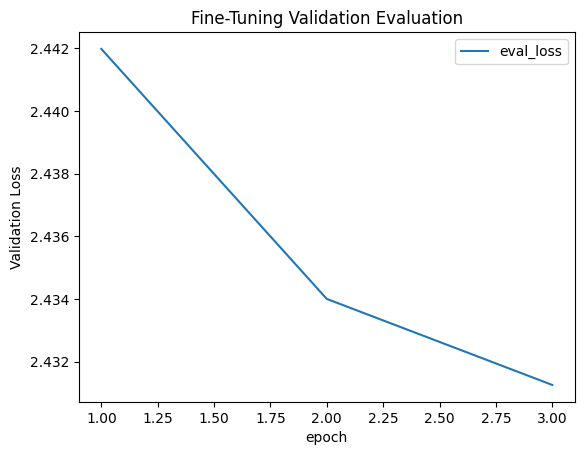

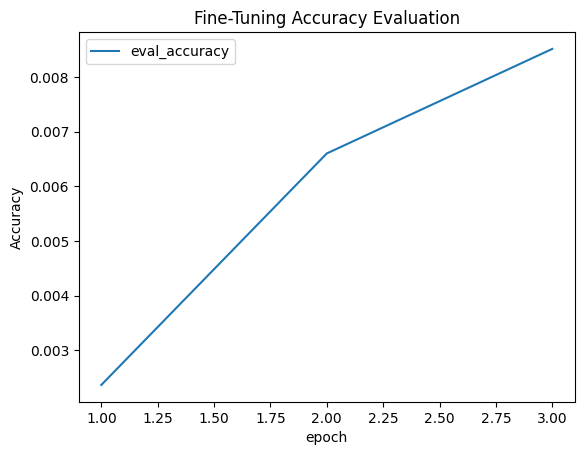

In [17]:
output=get_training_output(m2_trainer, ['loss', 'eval_loss', 'eval_accuracy'])
output

In [18]:
m_trainer.model.save_pretrained('./fine_tuned/mis/')
m2_trainer.model.save_pretrained('./fine_tuned/mis2/')

In [19]:
m_trainer.processing_class.save_pretrained('./fine_tuned/mis_token/')

('./fine_tuned/mis_token/tokenizer_config.json',
 './fine_tuned/mis_token/special_tokens_map.json',
 './fine_tuned/mis_token/tokenizer.model',
 './fine_tuned/mis_token/added_tokens.json',
 './fine_tuned/mis_token/tokenizer.json')

In [20]:
m2_trainer.processing_class.save_pretrained('./fine_tuned/mis2_token/')

('./fine_tuned/mis2_token/tokenizer_config.json',
 './fine_tuned/mis2_token/special_tokens_map.json',
 './fine_tuned/mis2_token/tokenizer.model',
 './fine_tuned/mis2_token/added_tokens.json',
 './fine_tuned/mis2_token/tokenizer.json')